# Introduction to Cloud Machine Learning with Flask API and CNTK



In [34]:
#load libraries
import os,sys
import pkg_resources
from flask import Flask, render_template, request, send_file
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import wget
import numpy as np
from PIL import Image, ImageOps
from urllib.request import urlretrieve
from cntk import load_model, combine


print("System version: {}".format(sys.version))
print("Flask version: {}".format(pkg_resources.get_distribution("flask").version))
print("CNTK version: {}".format(pkg_resources.get_distribution("cntk").version))

System version: 3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Flask version: 0.12
CNTK version: 2.0.beta9.0


## Image classification with a pretrained CNTK model
The model is a ResNet with 18 layers, but there are other models that you can try.

In [13]:
def maybe_download_model(filename='ResNet_18.model'):
    if(os.path.isfile(filename)):
        print("Model %s already downloaded" % filename)
    else:
        model_name_to_url = {
        'AlexNet.model':   'https://www.cntk.ai/Models/AlexNet/AlexNet.model',
        'AlexNetBS.model': 'https://www.cntk.ai/Models/AlexNet/AlexNetBS.model',
        'ResNet_18.model': 'https://www.cntk.ai/Models/ResNet/ResNet_18.model',
        }
        url = model_name_to_url[filename] #TODO: try/except in case incorrect filename
        wget.download(url)

In [14]:
model_name = 'ResNet_18.model'
maybe_download_model(model_name)

Model ResNet_18.model already downloaded


In [27]:
def read_synsets(filename='synsets.txt'):
    with open(filename, 'r') as f:
        synsets = [l.rstrip() for l in f]
        labels = [" ".join(l.split(" ")[1:]) for l in synsets]
    return labels

labels = read_synsets()
print("Label length: ", len(labels))


Label length:  1000


Let's read images with PIL, plot them and crop them to the ImageNet size: `224x224`.

In [30]:
def read_image_from_file(filename):
    img = Image.open(filename)
    return img
def read_image_from_request(image_request):
    img = Image.open(BytesIO(image_request.read())).convert('RGB')
    return img
def read_image_from_url(url):
    filename = urlretrieve(url)[0]
    return read_image_from_file(filename)

In [38]:
def plot_image(img):
    cmap = None
    plt.imshow(img)
    plt.axis('off')
    plt.show()

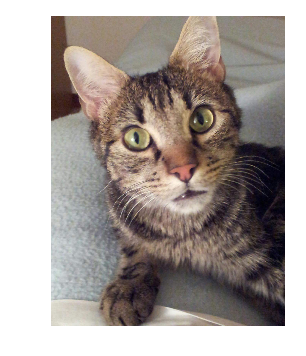

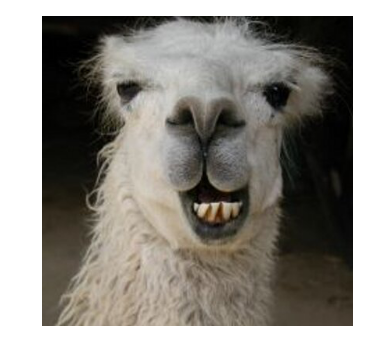

In [39]:
imagepath = 'neko.jpg'
img = read_image_from_file(imagepath)
plot_image(img)
imageurl = 'https://pbs.twimg.com/profile_images/269279233/llama270977_smiling_llama_400x400.jpg'
img2 = read_image_from_url(imageurl)
plot_image(img2)

Once we have the image, the model file and the sysntets, the next step is to load the model and perform a prediction.

In [40]:
%%time
z = load_model(model_name)

CPU times: user 984 ms, sys: 3.17 s, total: 4.16 s
Wall time: 26.1 s


In [89]:
def predict(model, image, labels, number_results = 5):
    #Crop and center the image
    img = ImageOps.fit(image, (224, 224), Image.ANTIALIAS)
    #Transform the image for CNTK format
    img = np.array(img, dtype=np.float32)
    img = np.ascontiguousarray(np.transpose(img, (2, 0, 1)))
    # Use last layer to make prediction
    z_out = combine([model.outputs[3].owner])
    result = np.squeeze(z_out.eval({z_out.arguments[0]:[img]}))
    # Sort probabilities 
    prob_idx = np.argsort(result)[::-1][:number_results]
    pred = [labels[i] for i in prob_idx]
    return pred
 

In [92]:
resp = predict(z, img, labels, 5)
print(resp)
resp = predict(z, img2, labels, 5)
print(resp)
resp = predict(z, read_image_from_url('http://www.awf.org/sites/default/files/media/gallery/wildlife/Hippo/Hipp_joe.jpg'), labels, 5)
print(resp)

['Egyptian cat', 'tiger cat', 'tabby, tabby cat', 'lynx, catamount', 'Siamese cat, Siamese']
['baboon', 'llama', 'patas, hussar monkey, Erythrocebus patas', 'macaque', 'chimpanzee, chimp, Pan troglodytes']
['hippopotamus, hippo, river horse, Hippopotamus amphibius', 'piggy bank, penny bank', 'warthog', 'hog, pig, grunter, squealer, Sus scrofa', 'dugong, Dugong dugon']


## Set up Flask API

In [17]:
import requests
headers = {'Content-type':'application/json'}
data = {"param":"1"}
try:
    res = requests.post('http://127.0.0.1:5000/api/v1/classify_image', data=json.dumps(data), headers=headers)
    print(res.content)
except Exception:
    print("ERROR: You should start the flask server!")
    print("To do it run 'python api.py' inside a cntk environment")

ERROR: You should start the flask server!
To do it run 'python api.py' inside a cntk environment
